In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.decomposition import PCA

from tqdm.auto import tqdm

colors = sns.color_palette("rocket")
colors

2024-09-18 18:48:28.144629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [2]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Text Segmentation/reviews.csv')
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo


In [3]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [4]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [5]:
class Text_Tokenization:
  def __init__(self,nlp,tokenizer):
    self.nlp = nlp
    self.tokenizer = tokenizer

  def _spacy_tokenizer(self,doc):
    return [token.lemma_ for token in self.nlp(doc) if
            not token.is_space]

  def _text_preprocessing(self,doc):
    doc = self._spacy_tokenizer(doc)

    return '|'.join(doc)

  def tokenize(self,doc,max_len,fit = False):
    doc = [self._text_preprocessing(text) for text in doc]

    if fit:
      self.tokenizer.fit_on_texts(doc)

    tokenized_doc = self.tokenizer.texts_to_sequences(doc)
    output = tf.keras.utils.pad_sequences(tokenized_doc,max_len,padding = 'post',truncating = 'post')

    return output

In [6]:
class Sentiment_rnn(tf.keras.Model):
  def __init__(self,vocab_size,embedding_size,hidden_size,n_classes):
    super().__init__()
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.n_classes = n_classes

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_size,mask_zero = True)
    self.rnn = tf.keras.layers.SimpleRNN(hidden_size,return_sequences = True)

    self.flatten = tf.keras.layers.Flatten()

    self.linear_1 = tf.keras.layers.Dense(64,activation = 'sigmoid')
    self.linear_2 = tf.keras.layers.Dense(128,activation = 'sigmoid')
    self.linear_3 = tf.keras.layers.Dense(n_classes,activation = 'softmax')

  def call(self,X):
    X = self.embedding(X)

    output = self.rnn(X)

    output = self.flatten(output)

    output = self.linear_1(output)
    output = self.linear_2(output)
    output = self.linear_3(output)

    return output

In [7]:
class Sentiment_lstm(tf.keras.Model):
  def __init__(self,vocab_size,embedding_size,hidden_size,n_classes):
    super().__init__()
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.n_classes = n_classes

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_size,mask_zero = True)
    self.lstm = tf.keras.layers.LSTM(hidden_size,return_sequences = True)

    self.flatten = tf.keras.layers.Flatten()

    self.linear_1 = tf.keras.layers.Dense(64,activation = 'sigmoid')
    self.linear_2 = tf.keras.layers.Dense(128,activation = 'sigmoid')
    self.linear_3 = tf.keras.layers.Dense(n_classes,activation = 'softmax')

  def call(self,X):
    X = self.embedding(X)

    output = self.lstm(X)

    output = self.flatten(output)

    output = self.linear_1(output)
    output = self.linear_2(output)
    output = self.linear_3(output)

    return output

In [8]:
class Train_Model:
  def __init__(self,model,lr,batch_size,epochs):
    self.model = model
    self.lr = lr
    self.batch_size = batch_size
    self.epochs = epochs

  def fit(self,X_train,y_train):
    model = self.model

    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr),
        metrics = ['accuracy']
    )

    print(f'Metrics on Train Data:')
    model.fit(X_train,y_train,batch_size = self.batch_size,epochs = self.epochs)
    self.model = model

    return model

  def eval(self,X_test,y_test):
    model = self.model

    print(f'\nMetrics on Test Data:')
    model.evaluate(X_test,y_test)

In [9]:
def Sentiment(model,review):
  tokenized_review = tokenization.tokenize([review],max_len)

  prediction = model(tokenized_review)
  label = tf.argmax(prediction,1)

  class_label = 'negative' if np.array(label)[0] == 0 else 'positive'

  print(f'{review} - {class_label}')

  return class_label

In [10]:
scores = df['score'].values

sentiment = np.where(scores < 3,0,1)
df['sentiment'] = sentiment

In [11]:
df = df[['content','sentiment']]
df.head(3)

,content,sentiment
0,I cannot open the app anymore,0
1,I have been begging for a refund from this app...,0
2,Very costly for the premium version (approx In...,0


In [12]:
target_feature = 'sentiment'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature)

In [13]:
eda.shape()

Number of samples in Data Set: 12495
Number of columns: 2


(12495, 2)

In [14]:
eda.unique_columns()

Unique columns:

Column 1: content
Column 2: sentiment


Index(['content', 'sentiment'], dtype='object')

In [15]:
eda.columns_dtypes()

Dtypes:

 content      object
sentiment     int64
dtype: object


content      object
sentiment     int64
dtype: object

In [16]:
eda.categorical_features()

Categorical features:

* content


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36629/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36629/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']


array(['content'], dtype='<U7')

In [17]:
eda.numerical_features()

Numerical features: 

* sentiment


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36629/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36629/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']


array(['sentiment'], dtype='<U9')

In [18]:
eda.count_NA()

Amout of Nans per class:


content      0
sentiment    0
dtype: int64

In [19]:
eda.duplicates()
df = df[df.duplicated() == False]

Amount of duplicates: 659


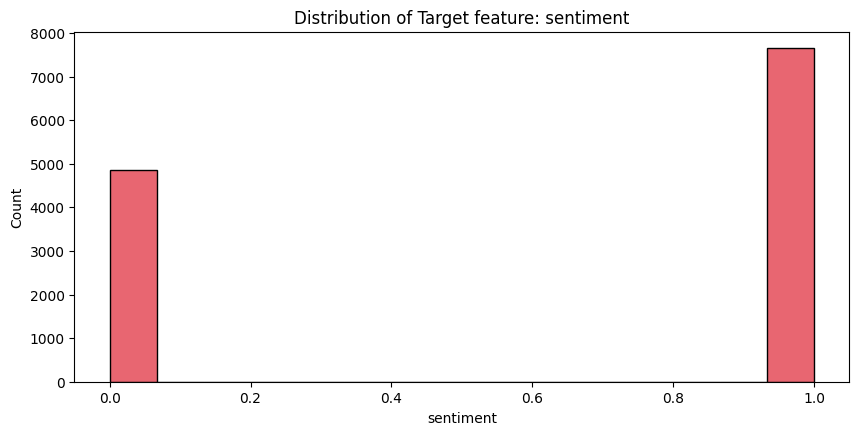

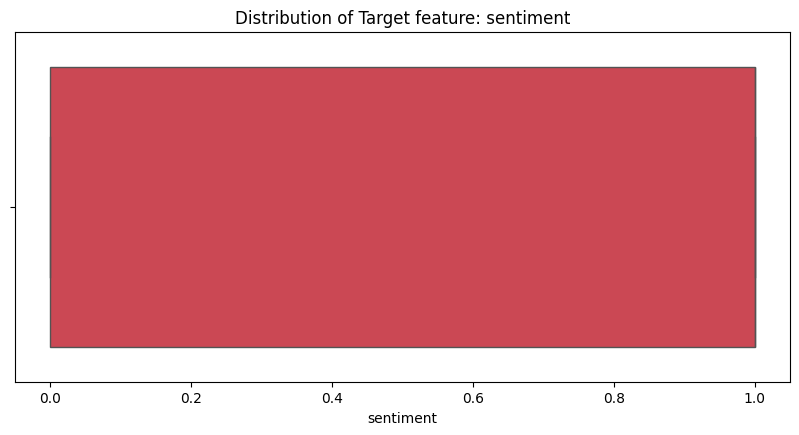

In [20]:
data_visualization.distribution_of_target_feature()

In [21]:
X = df['content'].values
y = df['sentiment'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [22]:
max_len = 80

tokenizer = Tokenizer(split = '|',oov_token = '<unk>')
tokenization = Text_Tokenization(nlp,tokenizer)

X_train = tokenization.tokenize(X_train,max_len,True)
X_test = tokenization.tokenize(X_test,max_len)

vocab = tokenization.tokenizer

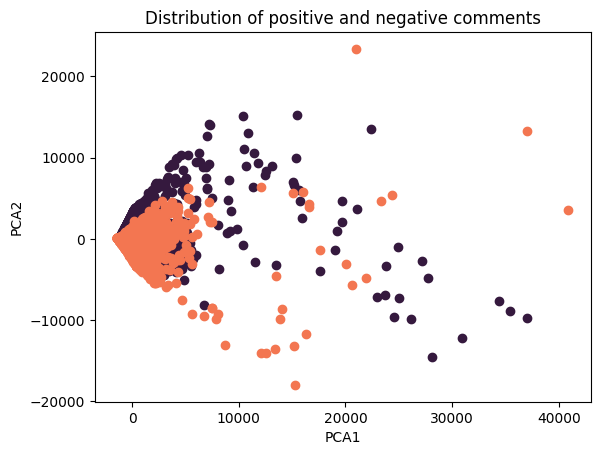

In [23]:
pca = PCA(n_components = 2)

positive_idxs = np.argwhere(y_train == 1)
negative_idxs = np.argwhere(y_train == 0)

positive_x = X_train[positive_idxs].squeeze()
negative_x = X_train[negative_idxs].squeeze()


positive_x_2d = pca.fit_transform(positive_x)
negative_x_2d = pca.fit_transform(negative_x)

plt.scatter(positive_x_2d[:,0],positive_x_2d[:,1],color = colors[0],label = 'positive')
plt.scatter(negative_x_2d[:,0],negative_x_2d[:,1],color = colors[4],label = 'negative')
plt.title('Distribution of positive and negative comments')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [24]:
vocab_size = len(vocab.word_index) + 1
embedding_size = 25
hidden_size = 128
n_classes = len(eda.unique_values(target_feature))

model_rnn = Sentiment_rnn(vocab_size,embedding_size,hidden_size,n_classes)
model_lstm = Sentiment_lstm(vocab_size,embedding_size,hidden_size,n_classes)

Unique values of sentiment: [0 1]


In [25]:
lr = 0.0001
batch_size = 32
epochs = 30

Trainer_rnn = Train_Model(model_rnn,lr,batch_size,epochs)
Trainer_lstm = Train_Model(model_lstm,lr,batch_size,epochs)

print(f'RNN model: ')
model_rnn = Trainer_rnn.fit(X_train,y_train)
Trainer_rnn.eval(X_test,y_test)

print(f'LSTM model: ')
model_lstm = Trainer_lstm.fit(X_train,y_train)
Trainer_lstm.eval(X_test,y_test)

RNN model: 
Metrics on Train Data:
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


296/296 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6072 - loss: 0.6578
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7628 - loss: 0.4985
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8171 - loss: 0.4048
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8525 - loss: 0.3570
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8830 - loss: 0.3000
Epoch 6/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8998 - loss: 0.2678
Epoch 7/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9256 - loss: 0.2202
Epoch 8/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9357 - loss: 0.1948
Epoch 9/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9500 - loss: 0.1659
Epoch 10/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9557 - loss: 0.1515
Epoch 11/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9660 - loss: 0.1196
Epoch 12/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/st

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'flatten_1' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.6135 - loss: 0.6584
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.7627 - loss: 0.4984
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.8170 - loss: 0.4172
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.8481 - loss: 0.3646
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.8634 - loss: 0.3331
Epoch 6/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.8750 - loss: 0.3101
Epoch 7/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.8931 - loss: 0.2806
Epoch 8/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.9093 - loss: 0.2472
Epoch 9/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9166 - loss: 0.2374
Epoch 10/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9275 - loss: 0.2149
Epoch 11/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9277 - loss: 0.2089
Epoch 12/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
review = df['content'].iloc[7]

Sentiment(model_rnn,review)

Reset my free trial, new phone I'd like to see if it's better. - negative


'negative'